In [227]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import scipy

In [228]:
class union_find():
    def __init__(self,h,w):
        self.parents = np.arange(h*w)
        self.ranking = np.zeros(h*w)
        
    def find(self, k):
        if self.parents[k] == k:
            return k
        return self.find(self.parents[k])

In [229]:
def region_labelling(image,pools):
    h,w,c = image.shape

    
    columns, rows = np.meshgrid(np.array([i for i in range(w)]),np.array([i for i in range(h)]))
    single_index = rows * w + columns

    cost_adj_hor = np.sqrt(np.sum((image[:,:-1,:] - image[:,1:,:])**2, axis = 2))
    cost_two_hor_index = list(zip(cost_adj_hor.flatten(),single_index[:,:-1].flatten(),single_index[:,1:].flatten()))
    
    cost_adj_ver = np.sqrt(np.sum((image[:-1,:,:] - image[1:,:,:])**2, axis = 2))
    cost_two_ver_index = list(zip(cost_adj_ver.flatten(),single_index[:-1,:].flatten(),single_index[1:,:].flatten()))

    cost_adj_diag_left = np.sqrt(np.sum((image[:-1,:-1,:] - image[1:,1:,:])**2, axis = 2))
    cost_two_diag_left_index = list(zip(cost_adj_diag_left.flatten(),single_index[:-1,:-1].flatten(),single_index[1:,1:].flatten()))   

    cost_adj_diag_right = np.sqrt(np.sum((image[1:,:-1,:] - image[:-1,1:,:])**2, axis = 2))
    cost_two_diag_right_index = list(zip(cost_adj_diag_right.flatten(),single_index[1:,:-1].flatten(),single_index[:-1,1:].flatten()))  
    
    total_costs = cost_two_hor_index + cost_two_ver_index + cost_two_diag_left_index + cost_two_diag_right_index
    incre_cost = sorted(total_costs)
    
    
    class_instant = union_find(h,w)
    
    total_vals = h*w

    for tup in range(len(incre_cost)):
        if total_vals <= pools:
            break
        else:
            x = incre_cost[tup][1]
            y = incre_cost[tup][2]
            
            px = class_instant.find(x)
            py = class_instant.find(y)

            if px != py:
                if class_instant.ranking[px] > class_instant.ranking[py]:
                    px,py = py,px
                elif class_instant.ranking[px] == class_instant.ranking[py]:
                    class_instant.ranking[py] += 1
                class_instant.parents[px] = py
                total_vals -= 1
    
    all_parents = {}
    pixel_value = 0
    label_frequency = {}
    labelled_img = np.empty((h,w),dtype = int)
    for i in range(h):
        for j in range(w):
            par = class_instant.find(i*w + j)
            if all_parents.get(par) is None:
                all_parents[par] = pixel_value
                label_frequency[all_parents[par]] = 0
                pixel_value += 1
            labelled_img[i][j] = all_parents[par]

            label_frequency[all_parents[par]] += 1

    return labelled_img,label_frequency
            


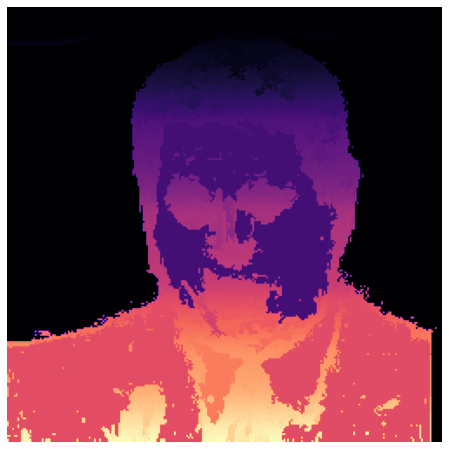

In [230]:
img = cv2.imread("Al_Gore_0004.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

labels, label_counts = region_labelling(img_lab, img_lab.shape[0] * img_lab.shape[1] // 8)

plt.figure(figsize = (8,8))
plt.imshow(labels,cmap = 'magma')
plt.axis('off')
plt.show()

In [232]:
def noise_image(grey_scale_image,labelled_image,label_frequency,l1,minl1,maxl1,l2,minl2,maxl2):
    
    grey_scale_image = grey_scale_image/255
    h,w = grey_scale_image.shape
    
    label_frequency_vals = np.array(list(label_frequency.values()))
   
    noisy_image = np.empty((h,w),dtype = int)

    
    number_of_parents = len(label_frequency_vals)    
 
  
    grey_parent = np.zeros(number_of_parents)

    for i in range(h):
        for j in range(w):
            grey_parent[labelled_image[i][j]] += grey_scale_image[i][j]

    grey_parent = grey_parent/np.array(label_frequency_vals)

    threshold1 = (l1*(1 - grey_scale_image))**2
    
    threshold2 = (l2*(1 - grey_scale_image))**2
    rand_img = np.random.random((h,w))

    first_part = np.zeros((h,w))
    first_part1 = np.zeros((h,w))
    first_part1[rand_img <= threshold1] = minl1
    first_part2 = np.zeros((h,w))
    first_part2[rand_img > threshold1] = maxl1

    first_part = first_part1 + first_part2
    
    second_part = np.zeros((h,w))
    second_part1 = np.zeros((h,w))
    second_part1[rand_img <= threshold2] = minl2
    second_part2 = np.zeros((h,w))
    second_part2[rand_img > threshold2] = maxl2
    
    second_part = second_part1 + second_part2
    
    points_selection = np.zeros((h,w),dtype = int)

    for i in range(h):
        for j in range(w):
            points_selection[i][j] = int(grey_scale_image[i][j] <= grey_parent[labelled_image[i][j]])
    
    noisy_image = first_part*points_selection + second_part*(1 - points_selection)
    #noisy_image = first_part

    return noisy_image


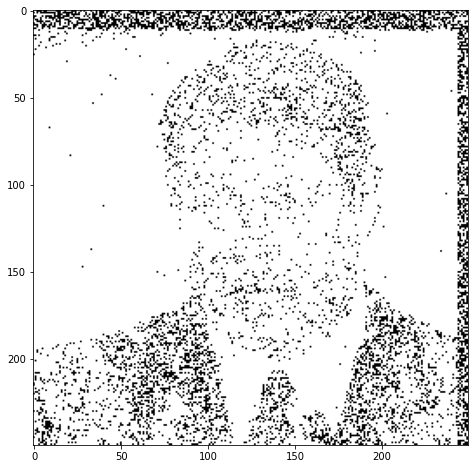

In [233]:
im_noise = noise_image(img_gray, labels, label_counts,0.7,0,255,0.3,0,255)
figure = plt.figure(figsize=(8,8))

plt.imshow(im_noise,cmap = 'gray')
plt.show()

In [234]:
def vector_field(grayImage,labelled_img, label_frequency,blur_sigma = 1,blur_size =7,threshold = 0.5):
    h = grayImage.shape[0]
    w = grayImage.shape[1]

    out = cv2.GaussianBlur(grayImage,(blur_size,blur_size),blur_sigma)
    outx = cv2.Sobel(out,cv2.CV_64F,1,0,ksize=3)
    outy = cv2.Sobel(out,cv2.CV_64F,0,1,ksize=3)
    rotate_out = np.concatenate((outx.reshape(h,w,1),np.array(-1*outy).reshape(h,w,1)),axis=2)/255
    bool_array = (rotate_out[:,:,1]<0).astype(int)
    replicate_bool = np.concatenate((bool_array.reshape(h,w,1),bool_array.reshape(h,w,1)),axis = 2)
    
    rotate_out = rotate_out*(1 - 2*replicate_bool)
    mean_vectors = np.zeros((len(label_frequency),2))
    variance_vectors = np.zeros((len(label_frequency),1))
    for i in range(h):
        for j in range(w):
            mean_vectors[labelled_img[i,j],:] += rotate_out[i,j,:] #np.reshape(rotate_out[i,j,:],1,2)
    
    for i in range(len(label_frequency)):
        mean_vectors[i,:] /= label_frequency[i]
    
    for i in range(h):
        for j in range(w):
            variance_vectors[labelled_img[i,j]] += np.sum((rotate_out[i,j,:] - mean_vectors[labelled_img[i,j],:])**2)

    for i in range(len(label_frequency)):
        variance_vectors[i] /= label_frequency[i]
    
    for i in range(h):
        for j in range(w):
            if variance_vectors[labelled_img[i,j]] <= threshold:
                rotate_out[i,j,:] = mean_vectors[labelled_img[i,j],:]
    
    sum_vals = (np.sum(rotate_out**2,axis = 2))**0.5 + np.exp(-2)
    replicate = np.concatenate((sum_vals.reshape(h,w,1),sum_vals.reshape(h,w,1)),axis = 2)
    rotate_out = rotate_out / replicate

    return rotate_out

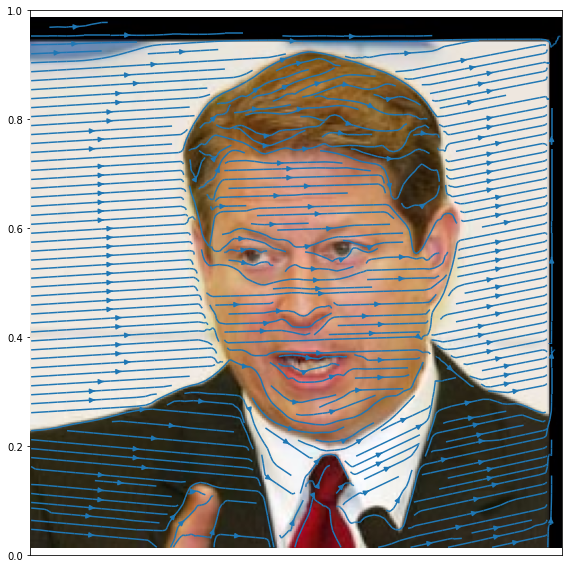

In [235]:
streamlines = vector_field(img_gray, labels, label_counts)
figure = plt.figure(figsize=(8,8))
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.imshow(img)
plt.axis('off')
X, Y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
skip = 10
#plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], streamlines[::skip, ::skip, 1], streamlines[::skip, ::skip, 0])
plt.streamplot(X, Y, streamlines[:, :, 1], streamlines[:, :, 0], density=(2, 2))

plt.tight_layout()
plt.savefig('../LIC_streams.png')


In [203]:
def bilinear(F, x, normalize=True):
    
    H, W= F.shape[0],F.shape[1]
    u = int(np.floor(x[0]))
    v = int(np.floor(x[1]))
    fu = x[0]  - u
    fv = x[1]  - v

    #if u < 0 : u = 0
    #elif u >= H: u = H - 1
    #if v < 0 : v = 0
    #elif v >= W: v = W - 1
#
    #if u + 1 < 0 : up = 0
    #elif u + 1 >= H: up = H - 1
    #else: up = u + 1
    #if v + 1 < 0 : vp = 0
    #elif v + 1 >= W: vp = W - 1
    #else: vp = v + 1

    u, up = np.clip([u, u + 1], 0, H - 1)
    v, vp = np.clip([v, v + 1], 0, W - 1)
    
    f1 = F[u, v] * (1 - fv) + F[u, vp] * fv
    f2 = F[up, v] * (1 - fv) + F[up, vp] * fv
    result = f1 * (1 - fu) + f2 * fu

    if normalize:
        result /= np.sum(result ** 2) + 1e-2

    return result

In [222]:
def lic(im_noise,vectorlines,radi_field = 40,kernelsize = 7):
    h,w = im_noise.shape
    checked = np.zeros((h,w))
    output = np.zeros((h,w))

    filter = np.arange(1,kernelsize+1)
    filter = np.minimum(filter,filter[::-1])
    filter = filter/np.sum(filter)
    df = lambda y, t: bilinear(vectorlines, y)
    odeopts = {'rtol': 1e-2, 'atol': 1e-2}
    coordinates = []    
    for i in range(h):
        for j in range(w):
            coordinates.append((i,j))

    randomize_coordinates = np.random.permutation(coordinates)
    for sp_pix in randomize_coordinates:
        i,j = sp_pix
        if checked[i][j] == 0:

            st_line = np.zeros((2*radi_field + 1,2))
            st_line[radi_field][0] = i 
            st_line[radi_field][1] = j 
            
            move_ahead = scipy.integrate.odeint(df,st_line[radi_field,:],np.arange(radi_field + 1),**odeopts)
            move_back = scipy.integrate.odeint(df,st_line[radi_field,:],-np.arange(radi_field + 1),**odeopts)

            st_line[radi_field:,:] = move_ahead
            st_line[:radi_field,:] = move_back[1:][::-1]
            
            vals = []
            for k in range(2*radi_field + 1):
                vals.append(bilinear(im_noise,st_line[k,:],False))

            vals = np.array(vals)
            conv_vals = scipy.signal.convolve(vals,filter,mode = 'same')
            ii_lin = np.floor(st_line[kernelsize - 1:-(kernelsize - 1),0]).astype(int)
            jj_lin = np.floor(st_line[kernelsize - 1:-(kernelsize - 1),1]).astype(int)

            conv_lin = conv_vals[kernelsize - 1:-(kernelsize - 1)]
            for i in range(len(ii_lin)):
                if ii_lin[i] >= 0 and ii_lin[i] < h and jj_lin[i] >= 0 and jj_lin[i] < w:
                    checked[ii_lin[i]][jj_lin[i]] += 1
                    output[ii_lin[i]][jj_lin[i]] += conv_lin[i]

    return (output/checked)/np.max(output)


In [239]:
gg = lic(im_noise,streamlines)

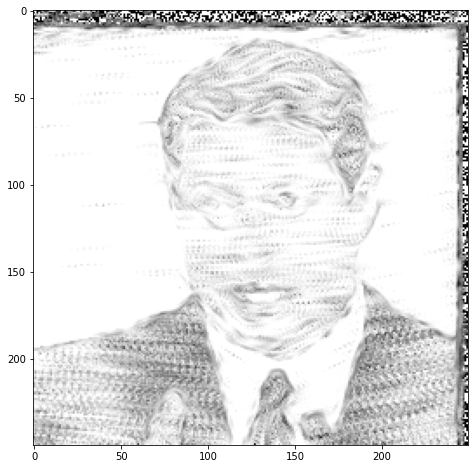

In [242]:
figure = plt.figure(figsize=(8,8))
plt.imshow(gg,cmap = 'gray')
plt.show()